In [1]:
import logging
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report)
from scipy.stats import zscore
import joblib
from time import time
import warnings
from typing import Tuple, Union
from datetime import datetime, timedelta
import logging
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score, classification_report
import pandas as pd
import joblib
from time import time
from typing import Tuple
import numpy as np
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from datetime import datetime
from tqdm import tqdm # For progress bar
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
%load_ext bigquery_magics

# "Will it snow tomorrow?" - The time traveler asked
The following dataset contains climate information from over 9000 stations accross the world. The overall goal of these subtasks will be to predict whether it will snow tomorrow 20 years ago. So if today is 1 April 2025 then the weather we want to forecast is for the 2 April 2005. You are supposed to solve the tasks using Big Query, which can be used in the Jupyter Notebook like it is shown in the following cell. For further information and how to use BigQuery in Jupyter Notebook refer to the Google Docs. 

The goal of this test is to test your coding knowledge in Python, BigQuery and Pandas as well as your understanding of Data Science. If you get stuck in the first part, you can use the replacement data provided in the second part.

In [3]:
%%bigquery
SELECT
*,
FROM `bigquery-public-data.samples.gsod`
LIMIT 20 


Query is running:   0%|          |

Downloading:   0%|          |

,station_number,wban_number,year,month,day,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_sealevel_pressure,...,min_temperature,min_temperature_explicit,total_precipitation,snow_depth,fog,rain,snow,hail,thunder,tornado
0,38940,99999,1929,11,18,40.500000,4,36.799999,4,1019.200012,...,NaN,<NA>,NaN,NaN,False,False,False,False,False,False
1,33110,99999,1929,11,14,42.299999,4,38.000000,4,1001.799988,...,NaN,<NA>,NaN,NaN,False,False,False,False,False,False
2,30910,99999,1929,10,12,53.200001,4,NaN,<NA>,1018.099976,...,NaN,<NA>,0.00,NaN,False,False,False,False,False,False
3,30910,99999,1929,12,12,41.200001,4,NaN,<NA>,993.500000,...,NaN,<NA>,0.12,NaN,False,False,False,False,False,False
4,33790,99999,1929,12,22,32.799999,4,31.700001,4,991.400024,...,NaN,<NA>,NaN,NaN,True,True,True,True,True,True
5,38110,99999,1929,10,31,46.299999,4,38.000000,4,1029.599976,...,NaN,<NA>,0.00,NaN,False,False,False,False,False,False
6,37770,99999,1929,9,1,65.500000,4,58.799999,4,1014.400024,...,NaN,<NA>,0.00,NaN,False,False,False,False,False,False
7,30750,99999,1929,11,22,49.000000,4,48.000000,4,998.000000,...,NaN,<NA>,0.00,NaN,True,True,True,True,True,True
8,31590,99999,1929,12,7,42.799999,4,38.500000,4,967.599976,...,NaN,<NA>,NaN,NaN,False,False,False,False,False,False
9,33790,99999,1929,11,27,42.000000,4,37.900002,4,1010.799988,...,NaN,<NA>,0.00,NaN,False,False,False,False,False,False


## Part 1

### 1. Task
Change the date format to 'YYYY-MM-DD' and select the data from 2000 till 2005 for station numbers including and between 725300 and 726300 , and save it as a pandas dataframe. Note the maximum year available is 2010. 

In [4]:
%%bigquery raw_weather_data
SELECT
    FORMAT_DATE('%Y-%m-%d', DATE(year, month, day)) AS date,
    *
FROM `bigquery-public-data.samples.gsod`
WHERE year BETWEEN 2000 AND 2005
    AND station_number BETWEEN 725300 AND 726300


Query is running:   0%|          |

Downloading:   0%|          |

### 2. Task 
From here you want to work with the data from all stations 725300 to 725330 that have information from 2000 till 2005. 

In [5]:
%%bigquery
CREATE  VIEW `challenge_data.weather_data_2000_2005` AS
SELECT
    FORMAT_DATE('%Y-%m-%d', DATE(year, month, day)) AS date,
    *
FROM `bigquery-public-data.samples.gsod`
WHERE year BETWEEN 2000 AND 2005
    AND station_number BETWEEN 725300 AND 725330 ;


Executing query with job ID: a1f120be-c130-4e7a-862c-c16b5177f90d
Query executing: 0.55s


ERROR:
 409 Already Exists: Table midyear-pattern-440517-g6:challenge_data.weather_data_2000_2005; reason: duplicate, message: Already Exists: Table midyear-pattern-440517-g6:challenge_data.weather_data_2000_2005

Location: US
Job ID: a1f120be-c130-4e7a-862c-c16b5177f90d



In [6]:
%%bigquery
SELECT
    *,
FROM `challenge_data.weather_data_2000_2005`

LIMIT 20 

Query is running:   0%|          |

Downloading:   0%|          |

,date,station_number,wban_number,year,month,day,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,...,min_temperature,min_temperature_explicit,total_precipitation,snow_depth,fog,rain,snow,hail,thunder,tornado
0,2000-06-22,725327,99999,2000,6,22,77.699997,8,56.099998,8,...,NaN,<NA>,0.00,NaN,False,False,False,False,False,False
1,2000-03-12,725327,99999,2000,3,12,38.500000,15,18.200001,15,...,NaN,<NA>,0.00,NaN,False,False,False,False,False,False
2,2000-02-21,725305,99999,2000,2,21,28.200001,19,22.700001,19,...,NaN,<NA>,0.00,NaN,False,False,False,False,False,False
3,2000-01-09,725317,99999,2000,1,9,41.700001,22,37.000000,15,...,NaN,<NA>,NaN,NaN,False,False,False,False,False,False
4,2000-11-25,725327,99999,2000,11,25,33.799999,22,26.100000,22,...,NaN,<NA>,0.02,NaN,False,False,False,False,False,False
5,2000-02-17,725316,99999,2000,2,17,28.799999,23,23.000000,23,...,NaN,<NA>,NaN,NaN,False,False,False,False,False,False
6,2000-07-15,725305,99999,2000,7,15,71.699997,23,61.400002,23,...,NaN,<NA>,0.00,NaN,False,False,False,False,False,False
7,2000-04-21,725314,99999,2000,4,21,51.299999,23,36.900002,23,...,NaN,<NA>,0.00,NaN,False,False,False,False,False,False
8,2000-07-04,725305,99999,2000,7,4,70.099998,23,64.800003,23,...,NaN,<NA>,0.00,NaN,False,False,False,False,False,False
9,2000-04-25,725316,99999,2000,4,25,51.900002,24,33.799999,24,...,NaN,<NA>,0.00,NaN,False,False,False,False,False,False


Start by checking which year received the most snowfall in our data. 

In [7]:
%%bigquery
SELECT 
    year, COUNTIF(snow) AS snow_days, avg(snow_depth) AS avg_snow,
FROM `challenge_data.weather_data_2000_2005`
GROUP BY year
ORDER BY snow_days DESC



Query is running:   0%|          |

Downloading:   0%|          |

,year,snow_days,avg_snow
0,2005,826,3.001899
1,2000,797,5.368812
2,2001,759,4.548462
3,2002,745,2.752885
4,2003,555,2.109028
5,2004,262,2.998462


Add an additional field that indicates the daily change in snow depth measured at every station. And identify the station and day for which the snow depth increased the most.  

In [8]:
%%bigquery
SELECT
    *,
    snow_depth - LAG(snow_depth) OVER (PARTITION BY station_number ORDER BY date) AS snow_depth_change
FROM
    `challenge_data.weather_data_2000_2005`
WHERE
    snow_depth IS NOT NULL
QUALIFY
    snow_depth_change IS NOT NULL
ORDER BY
    snow_depth_change DESC
LIMIT 20


Query is running:   0%|          |

Downloading:   0%|          |

,date,station_number,wban_number,year,month,day,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,...,min_temperature_explicit,total_precipitation,snow_depth,fog,rain,snow,hail,thunder,tornado,snow_depth_change
0,2005-01-22,725300,94846,2005,1,22,18.700001,24,14.600000,24,...,<NA>,0.50,11.8,True,True,True,True,True,True,9.8
1,2002-01-31,725300,94846,2002,1,31,31.400000,24,30.400000,24,...,<NA>,0.88,9.1,True,True,True,True,True,True,7.9
2,2000-12-11,725300,94846,2000,12,11,25.400000,24,22.400000,24,...,<NA>,0.02,9.1,True,True,True,True,True,True,7.9
3,2004-12-23,725330,14827,2004,12,23,18.000000,24,12.900000,24,...,<NA>,0.06,7.9,True,True,True,True,True,True,6.7
4,2000-02-19,725300,94846,2000,2,19,29.299999,24,23.900000,24,...,<NA>,0.19,9.1,True,True,True,True,True,True,6.0
5,2005-12-09,725330,14827,2005,12,9,17.400000,24,13.600000,24,...,<NA>,0.31,7.9,True,True,True,True,True,True,5.9
6,2002-12-25,725330,14827,2002,12,25,27.000000,24,23.600000,24,...,<NA>,0.22,7.1,True,True,True,True,True,True,5.9
7,2000-12-30,725300,94846,2000,12,30,25.600000,24,23.200001,24,...,<NA>,0.06,18.1,True,True,True,True,True,True,5.1
8,2000-12-12,725320,14842,2000,12,12,4.900000,24,-1.400000,24,...,<NA>,0.26,7.1,True,True,True,True,True,True,5.1
9,2000-01-30,725300,94846,2000,1,30,26.400000,24,23.799999,24,...,<NA>,0.06,7.9,True,True,True,True,True,True,4.8


In [9]:
%%bigquery
SELECT
    *,
    snow_depth - LAG(snow_depth) OVER (PARTITION BY station_number ORDER BY date) AS snow_depth_change
FROM
    `challenge_data.weather_data_2000_2005`
WHERE
    snow_depth IS NOT NULL
QUALIFY
    snow_depth_change IS NOT NULL
ORDER BY
    snow_depth_change DESC
LIMIT 20

Query is running:   0%|          |

Downloading:   0%|          |

,date,station_number,wban_number,year,month,day,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,...,min_temperature_explicit,total_precipitation,snow_depth,fog,rain,snow,hail,thunder,tornado,snow_depth_change
0,2005-01-22,725300,94846,2005,1,22,18.700001,24,14.600000,24,...,<NA>,0.50,11.8,True,True,True,True,True,True,9.8
1,2002-01-31,725300,94846,2002,1,31,31.400000,24,30.400000,24,...,<NA>,0.88,9.1,True,True,True,True,True,True,7.9
2,2000-12-11,725300,94846,2000,12,11,25.400000,24,22.400000,24,...,<NA>,0.02,9.1,True,True,True,True,True,True,7.9
3,2004-12-23,725330,14827,2004,12,23,18.000000,24,12.900000,24,...,<NA>,0.06,7.9,True,True,True,True,True,True,6.7
4,2000-02-19,725300,94846,2000,2,19,29.299999,24,23.900000,24,...,<NA>,0.19,9.1,True,True,True,True,True,True,6.0
5,2005-12-09,725330,14827,2005,12,9,17.400000,24,13.600000,24,...,<NA>,0.31,7.9,True,True,True,True,True,True,5.9
6,2002-12-25,725330,14827,2002,12,25,27.000000,24,23.600000,24,...,<NA>,0.22,7.1,True,True,True,True,True,True,5.9
7,2000-12-30,725300,94846,2000,12,30,25.600000,24,23.200001,24,...,<NA>,0.06,18.1,True,True,True,True,True,True,5.1
8,2000-12-12,725320,14842,2000,12,12,4.900000,24,-1.400000,24,...,<NA>,0.26,7.1,True,True,True,True,True,True,5.1
9,2000-01-30,725300,94846,2000,1,30,26.400000,24,23.799999,24,...,<NA>,0.06,7.9,True,True,True,True,True,True,4.8


Do further checks on the remaining dataset, clean or drop data depending on how you see appropriate. 

In [10]:
%%bigquery
SELECT 
    year,
    station_number,
    AVG(CAST(snow AS INT64)) AS avg_snow,
    COUNT(year) AS Observations
FROM `challenge_data.weather_data_2000_2005`
GROUP BY year, station_number
ORDER BY avg_snow DESC


Query is running:   0%|          |

Downloading:   0%|          |

,year,station_number,avg_snow,Observations
0,2002,725330,0.632877,365
1,2003,725330,0.608219,365
2,2005,725330,0.597260,365
3,2001,725330,0.580822,365
4,2001,725320,0.561644,365
5,2000,725320,0.557377,366
6,2000,725330,0.554645,366
7,2002,725320,0.550685,365
8,2000,725300,0.508197,366
9,2003,725320,0.482192,365


The rest of the data analysis needs to happen in python as my quota in google cloud was exceeded.

ERROR:
 403 Quota exceeded: Your project exceeded quota for free query bytes scanned. For more information, see https://cloud.google.com/bigquery/docs/troubleshoot-quotas; reason: quotaExceeded, location: unbilled.analysis, message: Quota exceeded: Your project exceeded quota for free query bytes scanned. For more information, see https://cloud.google.com/bigquery/docs/troubleshoot-quotas


In [11]:
%%bigquery raw_weather_data
SELECT 
    *
FROM `challenge_data.weather_data_2000_2005`
WHERE
    year BETWEEN 2000 AND 2005
    AND station_number BETWEEN 725300 AND 725330;

Query is running:   0%|          |

Downloading:   0%|          |

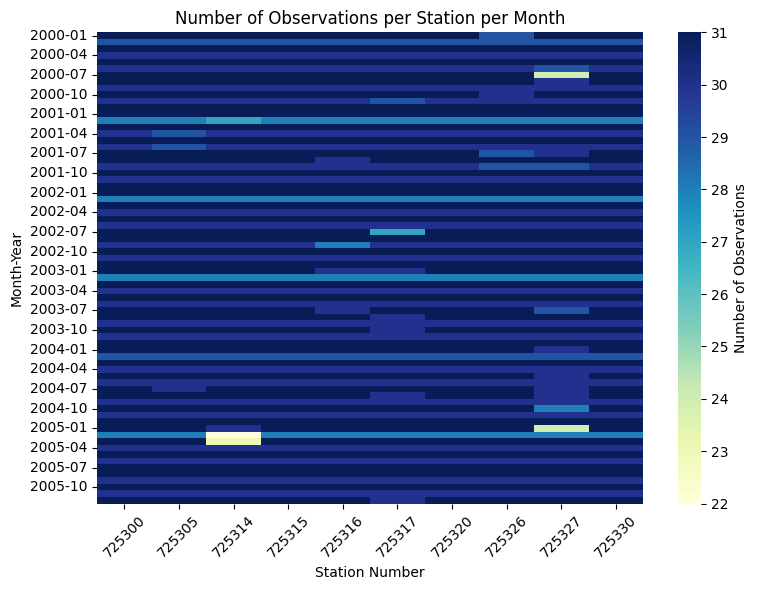

In [12]:
def visualize_observations_per_station(data: pd.DataFrame):
    
    # ensure the code does not modify the original data
    data = data.copy()

    # Convert 'date' to datetime if not already
    data['date'] = pd.to_datetime(data['date'])

    # Extract year and month
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month

    # Create a new column for year-month (as string for better display)
    data['year_month'] = data['date'].dt.to_period('M').astype(str)

    # Group by year_month and station_number
    grouped_data = data.groupby(['year_month', 'station_number']).size().reset_index(name='observations')
    # Pivot the data for heatmap
    pivot_data = grouped_data.pivot(index='year_month', columns='station_number', values='observations').fillna(0)

    # Plotting
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot_data, fmt='.0f', cmap='YlGnBu', cbar_kws={'label': 'Number of Observations'})
    plt.title('Number of Observations per Station per Month')
    plt.xlabel('Station Number')
    plt.ylabel('Month-Year')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

raw_weather_data = raw_weather_data # fix vs code bug thinking raw_weather_data is not defined from the bigquery cell

visualize_observations_per_station(raw_weather_data)

# Observations are mostly equally distributed across stations and months


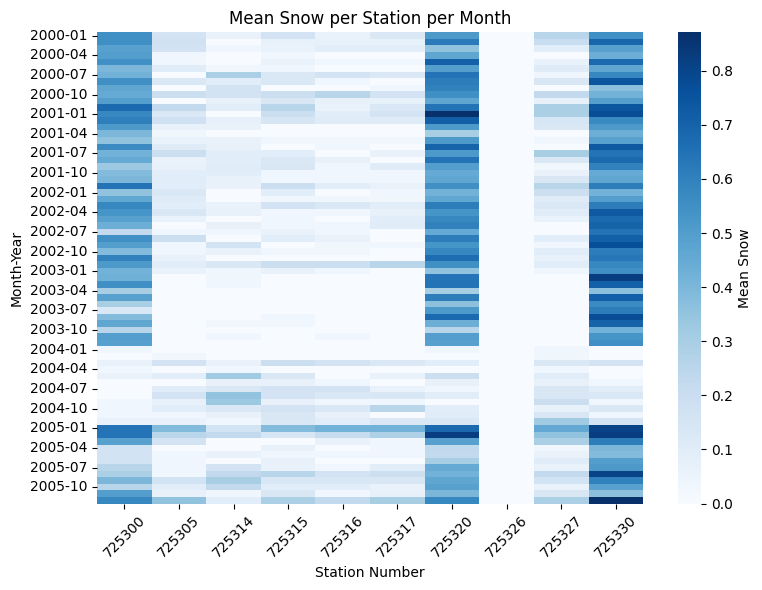

In [13]:
# visualize the number of observations per station per month and year with pandas and matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_mean_snow_per_station(data: pd.DataFrame):

    # ensure the code does not modify the original data
    data = data.copy()

    # Convert 'date' to datetime
    data['date'] = pd.to_datetime(data['date'])

    # Extract year and month
    data['year_month'] = data['date'].dt.to_period('M').astype(str)

    # Group by year_month and station_number, then compute mean snow
    grouped_data = data.groupby(['year_month', 'station_number'])['snow'].mean().reset_index()
    grouped_data['snow'] = grouped_data['snow'].astype(float)

    # Pivot for heatmap
    pivot_data = grouped_data.pivot(index='year_month', columns='station_number', values='snow').fillna(0)

    # Plotting
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot_data,  fmt='.1f', cmap='Blues', cbar_kws={'label': 'Mean Snow'})
    plt.title('Mean Snow per Station per Month')
    plt.xlabel('Station Number')
    plt.ylabel('Month-Year')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

visualize_mean_snow_per_station(raw_weather_data)

# Observation 1: The stations show varying levels of snowfall, with some stations consistently reporting higher snowfall than others.
# Observation 2: Snowfall for 2004 seems to be drasticly lower than in other years,
#                indicating a potential anomaly or change in weather patterns. -> Dont use 2004 data

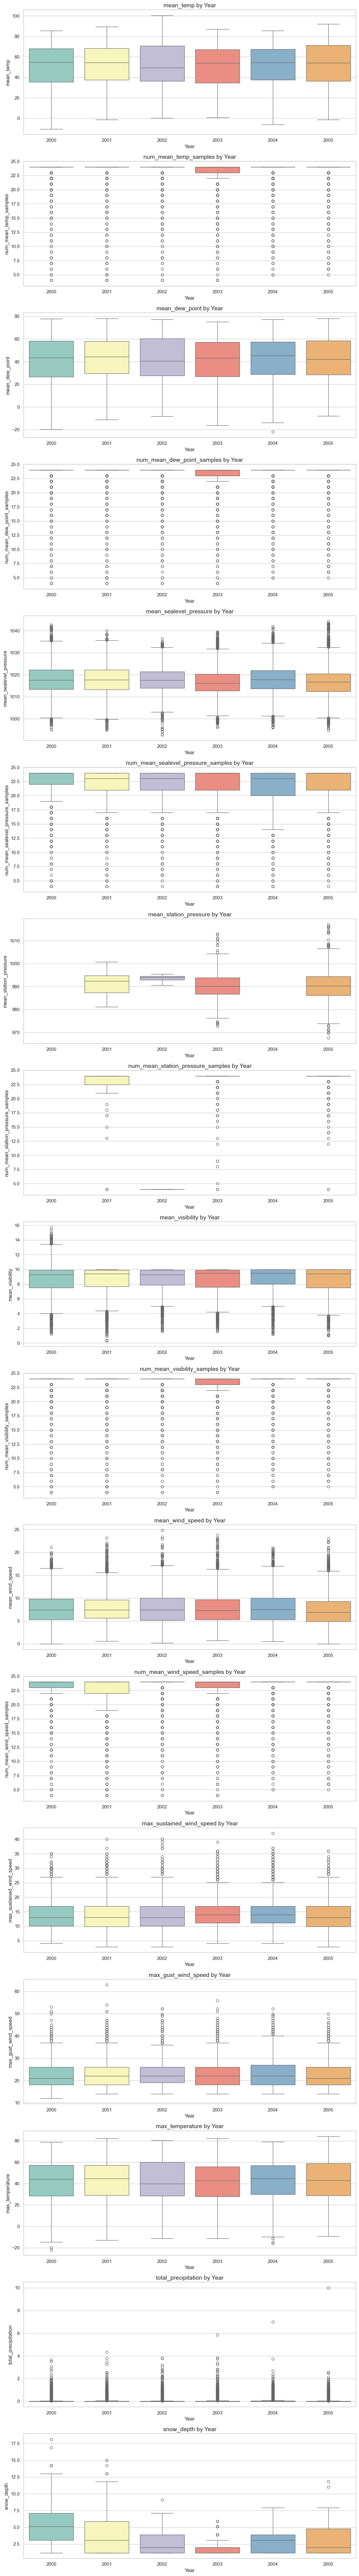

In [14]:
def boxplots_by_year(data: pd.DataFrame, numeric_cols: list):
    # Ensure 'date' is datetime
    data['date'] = pd.to_datetime(data['date'])

    # Extract year
    data['year'] = data['date'].dt.year

    # Set seaborn style
    sns.set_theme(style="whitegrid")

    # Create one subplot per numeric variable
    num_vars = len(numeric_cols)
    fig, axes = plt.subplots(nrows=num_vars, ncols=1, figsize=(12, 5 * num_vars), sharex=False)

    if num_vars == 1:
        axes = [axes]  # Make iterable if just one

    for ax, col in zip(axes, numeric_cols):
        sns.boxplot(
            data=data,
            x='year',
            y=col,
            hue='year',
            palette='Set3',
            ax=ax,
            legend=False,
            order=sorted(data['year'].unique())
        )
        ax.set_title(f'{col} by Year', fontsize=14)
        ax.set_xlabel('Year')
        ax.set_ylabel(col)

    plt.tight_layout()
    plt.show()


numeric_cols = raw_weather_data.select_dtypes(include='number').drop(columns=['year', 'month', 'day','station_number', 'wban_number', 'min_temperature']).columns.tolist()
boxplots_by_year(raw_weather_data, numeric_cols)


# Observation 1: Besides num_mean_station_pressure_samples the other numeric variables show a consistent distribution across the years.

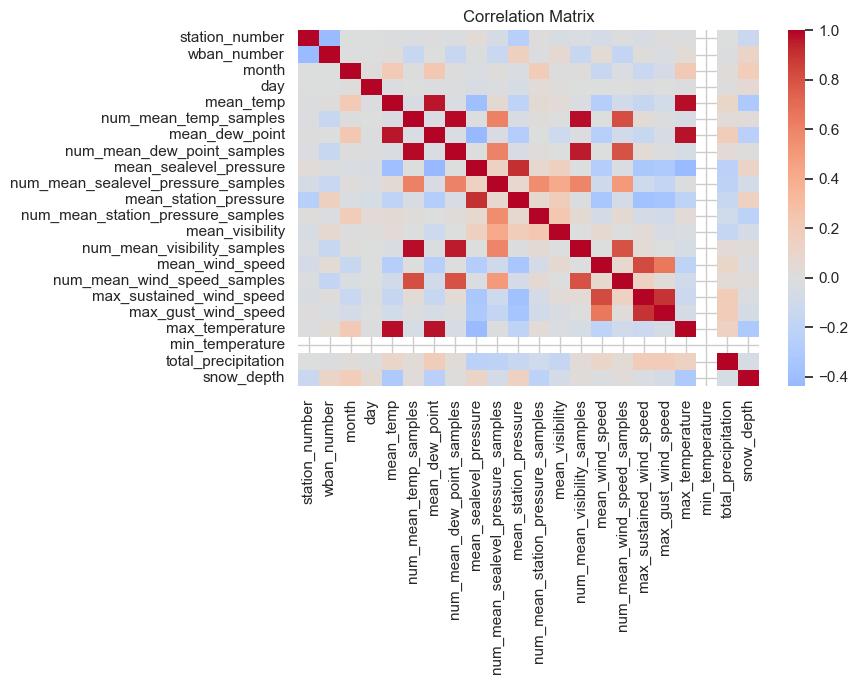

In [15]:
# visualise a heatmap of the correlation matrix of the numeric columns once for 2004 and once for all other years
def correlation_heatmaps(data: pd.DataFrame):
    # Ensure 'date' is datetime
    data['date'] = pd.to_datetime(data['date'])
    data['year'] = data['date'].dt.year

    # Select numeric columns (exclude 'year' to avoid bias)
    numeric_cols = data.select_dtypes(include='number').columns.drop('year', errors='ignore')

    # Calculate correlation matrices
    corr = data[numeric_cols].corr()

    # Plotting
    fig, axs = plt.subplots(figsize=(9, 7))

    sns.heatmap(corr, fmt=".2f", cmap='coolwarm', center=0)
    axs.set_title('Correlation Matrix')

    plt.tight_layout()
    plt.show()

correlation_heatmaps(raw_weather_data)

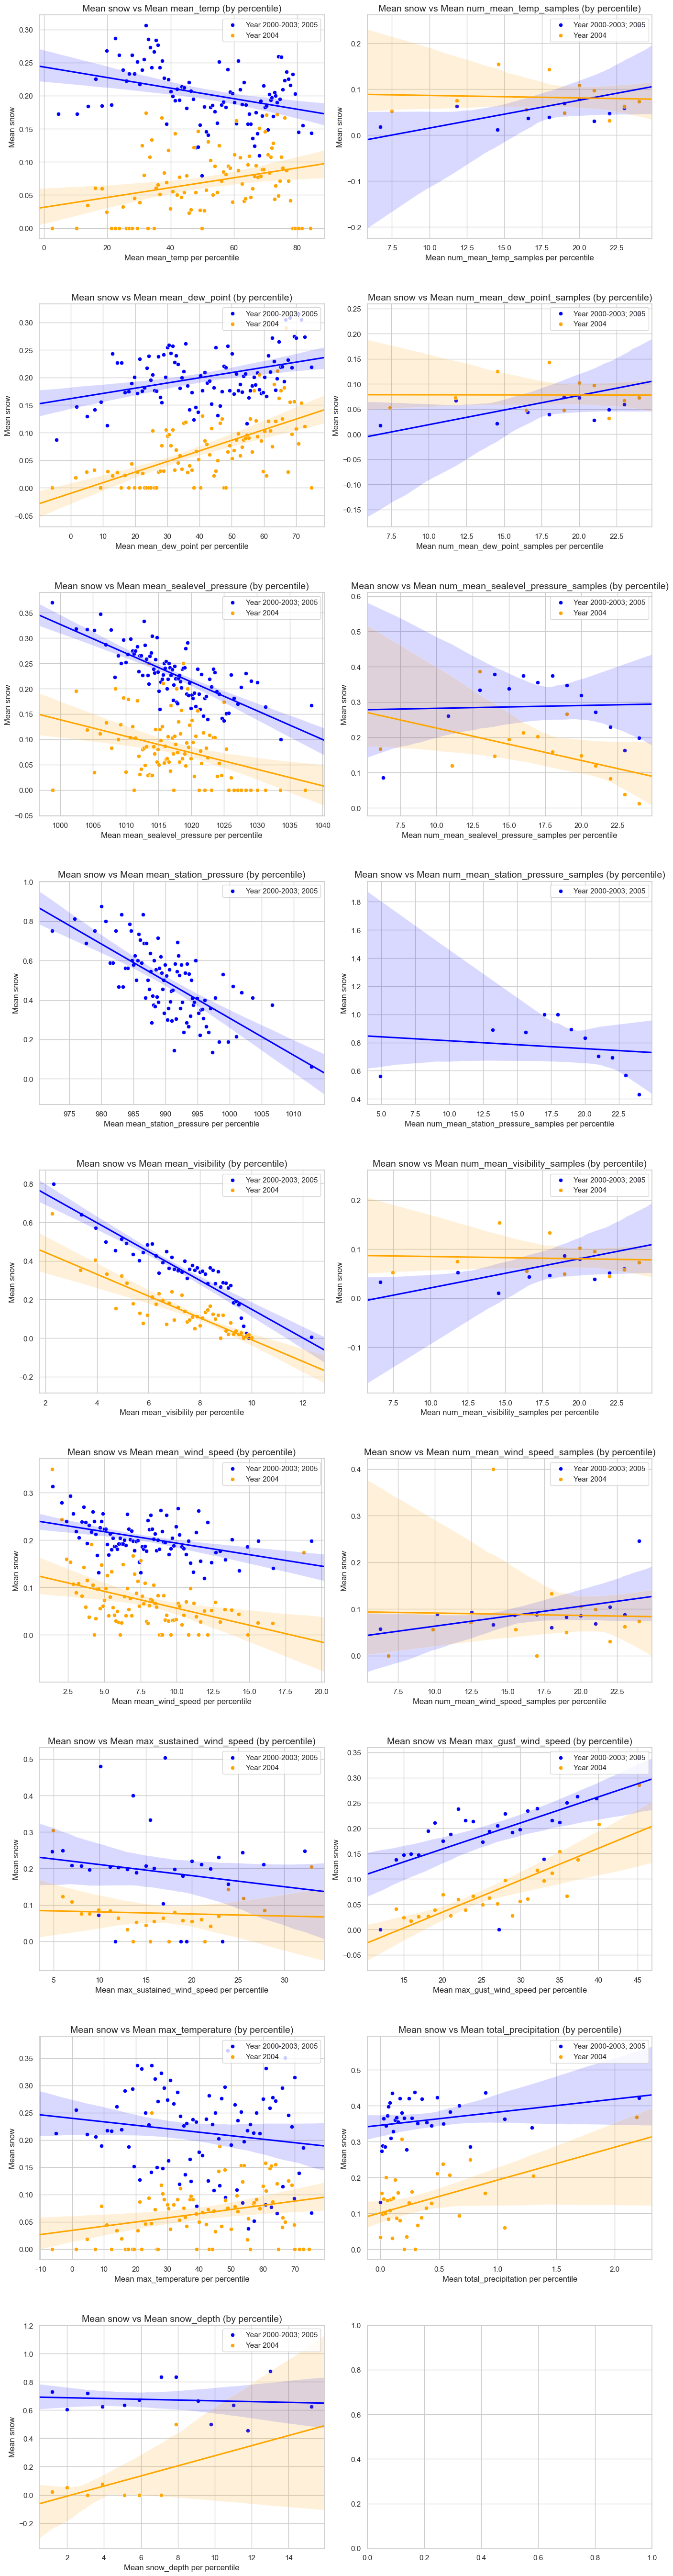

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

def scatter_mean_snow_for_all(data: pd.DataFrame, numeric_cols: list, snow_var: str = 'snow', year_col: str = 'year'):
    num_vars = len(numeric_cols)
    cols = 2
    rows = math.ceil(num_vars / cols)
    
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(14, 6 * rows), squeeze=False)
    axes = axes.flatten()
    
    plot_idx = 0
    for col in numeric_cols:
        if data[col].nunique(dropna=True) <= 1:
            print.info(f"Skipping column '{col}' due to insufficient unique values.")
            continue

        temp_data = data[[col, snow_var, year_col]].copy()
        temp_data = temp_data.dropna(subset=[col])

        temp_data[f'{col}_percentile'] = temp_data[col].rank(pct=True) * 100
        temp_data['percentile_group'] = pd.cut(
            temp_data[f'{col}_percentile'],
            bins=100,
            labels=False,
            include_lowest=True
        ) + 1

        # Split by year
        other_years = temp_data[temp_data[year_col] != 2004]
        year_2004 = temp_data[temp_data[year_col] == 2004]

        # Grouped data
        grouped_other = other_years.groupby('percentile_group').agg(
            mean_col=(col, 'mean'),
            mean_snow=(snow_var, 'mean')
        ).dropna().reset_index()

        grouped_2004 = year_2004.groupby('percentile_group').agg(
            mean_col=(col, 'mean'),
            mean_snow=(snow_var, 'mean')
        ).dropna().reset_index()

        ax = axes[plot_idx]

        # Plot scatter points
        sns.scatterplot(data=grouped_other, x='mean_col', y='mean_snow', color='blue', label='Year 2000-2003; 2005', ax=ax)
        sns.scatterplot(data=grouped_2004, x='mean_col', y='mean_snow', color='orange', label='Year 2004', ax=ax)

        # Plot trend lines
        sns.regplot(data=grouped_other, x='mean_col', y='mean_snow', scatter=False, color='blue', ax=ax, truncate=False)
        sns.regplot(data=grouped_2004, x='mean_col', y='mean_snow', scatter=False, color='orange', ax=ax, truncate=False)

        # Formatting
        ax.set_title(f'Mean {snow_var} vs Mean {col} (by percentile)', fontsize=14)
        ax.set_xlabel(f'Mean {col} per percentile')
        ax.set_ylabel(f'Mean {snow_var}')
        ax.grid(True)
        ax.legend(loc='upper right')

        plot_idx += 1

    plt.tight_layout(h_pad=4)
    plt.show()
scatter_mean_snow_for_all(raw_weather_data, numeric_cols)

# Observation 1: The scatter plots show a clear that the 2004 data points have a similar data distribution but consistently fewer snow days 
#                 -> Dont use the 2004 data

### 3. Task
Now it is time to split the data, into a training, evaluation and test set. As a reminder, the date we are trying to predict snow fall for should constitute your test set.

In [17]:
# Configure logging first

def configure_logging():
    """
    Configures the logging settings for the application.
    Removes all existing handlers to ensure logs are not duplicated or persisted across runs.
    """
    logger = logging.getLogger(__name__)
    # Remove all handlers associated with the logger
    for handler in logger.handlers[:]:
        logger.removeHandler(handler)
    handler = logging.StreamHandler()
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    logger.setLevel(logging.INFO)


def cyclic_day_of_year_encoding(date_series: pd.Series) -> pd.DataFrame:
    """
    Returns cyclic encoding (sin and cos) of the day-of-year from a datetime series.

    Parameters:
    -----------
    date_series : pd.Series
        A pandas Series containing datetime-like values (can be string or datetime).

    Returns:
    --------
    pd.DataFrame
        A DataFrame with two columns:
        - 'doy_sin': sine of day-of-year
        - 'doy_cos': cosine of day-of-year
    """
    # Convert to datetime if necessary
    dates = pd.to_datetime(date_series, errors='coerce')

    # Compute day of year
    doy = dates.dt.dayofyear

    # Encode cyclically
    sin_values = np.sin(2 * np.pi * doy / 365)
    cos_values = np.cos(2 * np.pi * doy / 365)

    return pd.DataFrame({
        'doy_sin': sin_values,
        'doy_cos': cos_values
    }, index=date_series.index)

def preprocesss_data(raw_data: pd.DataFrame, categorial_features:pd.DataFrame,) -> pd.DataFrame:
    
    # remove columns wich are the same as snow
    categorical_features = ['fog', 'rain', 'hail', 'thunder', 'tornado']
    cleaned_data = raw_data.drop(columns=categorical_features)

    # remove columns without data
    cleaned_data = cleaned_data.dropna(axis=1, how='all') # min_temperature

    # drop snow_depth
    cleaned_data = cleaned_data.drop(columns=['snow_depth'])

    # convert categorial features to strings
    cat_features = ['station_number', 'wban_number'] 
    cleaned_data[cat_features] = cleaned_data[cat_features].astype(str)

    # Represent date as two continuous cyclical features—sine and cosine of the day of the year—to capture seasonal cycles
    cleaned_data[['doy_sin', 'doy_cos']] = cyclic_day_of_year_encoding(cleaned_data['date'])

    return cleaned_data


def create_lagged_features(
    df: pd.DataFrame,
    target_column: str,
    n_lags: int = 21,
    columns_to_lag: list[str] = None,
    exclude_columns: list[str] = None,
    include_original_features: bool = True,
    lag_target: bool = False
) -> pd.DataFrame:

    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')

    if exclude_columns is None:
        exclude_columns = ['date']

    if columns_to_lag is None:
        columns_to_lag = [col for col in df.columns if col not in exclude_columns]

    lagged_frames = []
    for col in columns_to_lag:
        lagged_cols = {
            f'{col}_lag_{lag}': df[col].shift(lag)
            for lag in range(1, n_lags + 1)
        }
        lagged_frames.append(pd.DataFrame(lagged_cols, index=df.index))

    if lagged_frames:
        lagged_df = pd.concat(lagged_frames, axis=1)
        if include_original_features:
            df = pd.concat([df, lagged_df], axis=1)
        else:
            df = pd.concat([df[['date', target_column]], lagged_df], axis=1)

    return df





def temporal_train_eval_test_split_by_year(X, y, train_years, eval_years, test_years):
    """
    Splits data into train, eval, and test sets based on full calendar years.

    Args:
        X (pd.DataFrame): Features including a 'date' column (datetime type)
        y (pd.Series): Target variable
        train_years (list of int): List of years for the training set
        eval_years (list of int): List of years for the evaluation set
        test_years (list of int): List of years for the test set

    Returns:
        tuple: (X_train, X_eval, X_test, y_train, y_eval, y_test)
    """
    # Combine features and target
    data = X.copy()
    data['target'] = y

    # Ensure 'date' column is datetime
    if not pd.api.types.is_datetime64_any_dtype(data['date']):
        data['date'] = pd.to_datetime(data['date'])

    # Extract year
    data['year'] = data['date'].dt.year

    # Create splits based on year
    train = data[data['year'].isin(train_years)]
    eval_ = data[data['year'].isin(eval_years)]
    test = data[data['year'].isin(test_years)]

    # Check for temporal leakage
    assert train['date'].max() < eval_['date'].min(), "Temporal leakage: Train dates overlap evaluation"
    assert eval_['date'].max() < test['date'].min(), "Temporal leakage: Evaluation dates overlap test"

    # Logging date ranges
    logger.info("Train set date range: %s to %s", train['date'].min(), train['date'].max())
    logger.info("Eval set date range: %s to %s", eval_['date'].min(), eval_['date'].max())
    logger.info("Test set date range: %s to %s", test['date'].min(), test['date'].max())

    # Drop columns and separate features/target
    X_train = train.drop(columns=['date', 'year', 'target'])
    X_eval = eval_.drop(columns=['date', 'year', 'target'])
    X_test = test.drop(columns=['date', 'year', 'target'])

    y_train = train['target']
    y_eval = eval_['target']
    y_test = test['target']

    return X_train, X_eval, X_test, y_train, y_eval, y_test


# 2. Preprocessing Pipeline
def create_preprocessor(num_features: list, cat_features: list = None) -> ColumnTransformer:
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    transformers = [('num', numeric_transformer, num_features)]

    if cat_features:
        categorical_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])
        transformers.append(('cat', categorical_transformer, cat_features))

    return ColumnTransformer(transformers)


def filter_min_samples(X_train, y_train, columns, min_samples=5):
    """
    Filters out rows from training data where any of the specified columns have values less than min_samples.
    Ignores NaNs in the check (does not drop rows just because of NaN).
    Logs the number and percent of dropped rows.
    """
    initial_count = len(X_train)
    mask = X_train[columns].ge(min_samples) | X_train[columns].isna()
    mask = mask.all(axis=1)
    X_filtered = X_train[mask]
    y_filtered = y_train[mask]
    dropped = initial_count - len(X_filtered)
    percent = (dropped / initial_count) * 100 if initial_count > 0 else 0
    logger.info(f"Dropped {dropped} rows ({percent:.2f}%) from training data due to insufficient sample counts.")
    return X_filtered, y_filtered


def filter_outliers(X_train, y_train, columns: list, threshold=5):
    """
    Filters out rows from training data with Z-score above threshold (outliers), but does NOT drop rows just because of NaNs.

    Parameters:
    - X_train (pd.DataFrame): Training features.
    - y_train (pd.Series): Training labels.
    - threshold (float): Z-score threshold for detecting outliers.

    Returns:
    - pd.DataFrame: Filtered training features.
    - pd.Series: Filtered training labels.
    """
    # Only use float columns for zscore calculation
    numeric_train = X_train[columns]
    # Compute zscore, ignoring NaNs
    z_train = np.abs(zscore(numeric_train, nan_policy='omit'))
    # zscore returns a numpy array; convert to DataFrame for easier masking
    z_train_df = pd.DataFrame(z_train, index=numeric_train.index, columns=numeric_train.columns)
    # Only drop rows where ALL non-NaN zscores are below threshold (ignore NaNs)
    mask = (z_train_df < threshold) | z_train_df.isna()
    mask = mask.all(axis=1)

    initial_count = len(X_train)
    filtered_count = mask.sum()
    dropped = initial_count - filtered_count
    percent = (dropped / initial_count) * 100 if initial_count > 0 else 0

    logger.info(f"Dropped {dropped} rows ({percent:.2f}%) from training data due to outliers.")
    return X_train[mask], y_train[mask]

# 3. Model Definitions with Enhanced Hyperparameter Search Spaces
def get_models(Y_train: pd.Series) -> dict:
    """Define models with expanded hyperparameter search spaces for Bayesian Optimization."""
    # Calculate class weight ratio
    positive_count = sum(Y_train)
    negative_count = len(Y_train) - positive_count
    scale_pos_weight = negative_count / positive_count if positive_count > 0 else 1
    
    return {
        'LogisticRegression': {
            'model': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
            'search_space': {
                'classifier__C': Real(0.001, 100, prior='log-uniform'),
                'classifier__solver': Categorical(['lbfgs', 'liblinear', 'saga']), 
                #'classifier__penalty': Categorical(['l1', 'l2']),

            }
        },
        'DecisionTree': {
            'model': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
            'search_space': {
                'classifier__max_depth': Integer(1, 10),
                'classifier__min_samples_split': Integer(10, 100),
                'classifier__min_samples_leaf': Integer(10, 100),
            }
        },
        'RandomForest': {
            'model': RandomForestClassifier(random_state=42, class_weight='balanced'),
            'search_space': {
                'classifier__n_estimators': Integer(5, 100),
                'classifier__max_depth': Integer(1, 10),
                'classifier__min_samples_split': Integer(20, 100),
                'classifier__bootstrap': Categorical([True, False])
            }
        },
        'XGBoost': {
            'model': XGBClassifier(
                random_state=42,
                eval_metric='logloss',
                scale_pos_weight=scale_pos_weight,
            ),
            'search_space': {
                'classifier__n_estimators': Integer(1, 20),
                'classifier__max_depth': Integer(1, 5),
                'classifier__gamma': Real(0.05, 0.3), 
                'classifier__reg_alpha': Real(1e-6, 1, prior='log-uniform'),
                'classifier__reg_lambda': Real(1e-6, 10, prior='log-uniform'),
                'classifier__min_child_weight': Integer(1, 10),  
            }
        }
        # 'LightGBM': {
        #     'model': LGBMClassifier(
        #         random_state=42,
        #         scale_pos_weight=scale_pos_weight,
        #         subsample=0.8,
        #         colsample_bytree=0.8,
        #         verbosity =0, # Suppress LightGBM infos
            
        #     ),
        #     'search_space': {
        #         'classifier__n_estimators': Integer(5, 100),
        #         'classifier__max_depth': Integer(3, 50), # max is 16 for LightGBM
        #         'classifier__learning_rate': Real(0.01, 0.1, prior='log-uniform'),
        #         'classifier__reg_alpha': Real(1e-6, 1, prior='log-uniform'),
        #         'classifier__reg_lambda': Real(1e-6, 10, prior='log-uniform')
        #     }
        # },
        # 'CatBoost': {
        #     'model': CatBoostClassifier(
        #         random_state=42,
        #         verbose=0,
        #         scale_pos_weight=scale_pos_weight,
        #         bootstrap_type='Bernoulli',
        #         subsample=0.8
        #     ),
        #     'search_space': {
        #         'classifier__iterations': Integer(10, 30),
        #         'classifier__depth': Integer(3, 16),
        #         'classifier__learning_rate': Real(0.01, 0.1, prior='log-uniform'),
        #         'classifier__l2_leaf_reg': Real(1, 5),
        #         'classifier__border_count': Integer(1, 128)
        #     }
        # }
    }

# 4. Evaluation Function
def evaluate_model(model, X: pd.DataFrame, y: pd.Series, set_name: str = 'Validation') -> float:
    """Evaluate model and return F1 score."""
    y_pred = model.predict(X)
    f1 = f1_score(y, y_pred)
    
    return f1


def predict_snow_for_day(X: pd.DataFrame, Y: pd.Series, prediction_day, model) -> pd.DataFrame:
    """
    Predicts snowfall occurrence for a specific day using a trained model.

    Parameters
    ----------
    X : pd.DataFrame
        Feature data, must include a 'date' column.
    Y : pd.Series or pd.DataFrame
        True labels, must be aligned with X by index.
    prediction_day : datetime, str, or compatible format
        The specific day to filter for predictions.
    model : object
        A trained model with a .predict() method.

    Returns
    -------
    pd.DataFrame
        A DataFrame with index from X and columns: ['Actual', 'Predicted'],
        both cast to boolean type.
    """
    # Ensure 'date' column exists
    if 'date' not in X.columns:
        raise ValueError("Input DataFrame X must contain a 'date' column.")

    # Filter data for the prediction day
    X_day = X[X['date'] == prediction_day]
    if X_day.empty:
        raise ValueError(f"No data found for the prediction day: {prediction_day}")

    # Get corresponding labels
    Y_day = Y.loc[X_day.index]

    # Make predictions
    predictions = model.predict(X_day)

    # Build result DataFrame with boolean values
    results = pd.DataFrame({
        'Actual': Y_day.astype(bool),
        'Predicted': predictions.astype(bool)
    }, index=X_day.index)

    # Print log message and preview
    print(f"\nPrediction results for {prediction_day}:")

    return results

# 5. Main Training Function with Reporting (using BayesSearchCV)
def train_and_evaluate(
    X_train: pd.DataFrame, 
    Y_train: pd.Series,
    X_eval: pd.DataFrame,
    Y_eval: pd.Series,
    X_test: pd.DataFrame,
    Y_test: pd.Series,
    num_features: list,
    cat_features: list = None,
    n_iterations: int = 50 # Number of Bayesian Optimization iterations
) -> Tuple[pd.DataFrame, dict]:
    """Train and evaluate models with hyperparameter tuning using BayesSearchCV."""
    preprocessor = create_preprocessor(num_features, cat_features= cat_features)
    models_info = get_models(Y_train)
    tscv = TimeSeriesSplit(n_splits=3) # Still using TimeSeriesSplit for CV
    
    results = []
    best_models = {}
    
    for name, model_data in models_info.items():
        
        start_time = time()
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model_data['model'])
        ])
        
        # Bayesian optimization with cross-validation
        opt = BayesSearchCV(
            estimator=pipeline,
            search_spaces=model_data['search_space'],
            n_iter=n_iterations,
            cv=tscv, # Use TimeSeriesSplit for CV
            scoring='f1',
            n_jobs=-1,
            verbose=0, # Set to 0 to use tqdm for progress
            random_state=42,
            return_train_score=True
        )
        
        # Fit with progress bar
        with tqdm(total=n_iterations, desc=f"Optimizing {name}") as pbar:
            def on_step(optim_result):
                pbar.update(1)
            opt.fit(X_train, Y_train, callback=on_step)
        
        best_model = opt.best_estimator_
        best_models[name] = best_model

       
        # Evaluate
        train_f1 = evaluate_model(best_model, X_train, Y_train, 'Training')
        val_f1 = evaluate_model(best_model, X_eval, Y_eval, 'Validation')
        test_f1 = evaluate_model(best_model, X_test, Y_test, 'Test')
       
        # Record results
        results.append({
            'Model': name,
            'Training F1': train_f1,
            'Validation F1': val_f1,
            'Test F1': test_f1,
            'Training Time (s)': time() - start_time,
            'Best Params': str(opt.best_params_),
            
        })
        
        joblib.dump(best_model, f'{name.lower()}_model.pkl')
    
    # Create results table
    results_df = pd.DataFrame(results)
    results_df.set_index('Model', inplace=True)
    print("\nFinal Results:")
    print(results_df)
    
    return results_df, best_models


# setup logging
logger = logging.getLogger(__name__)
configure_logging()

# 1. Preprocess data
categorial_features = ['station_number', 'wban_number']
weather_data = preprocesss_data(raw_data=raw_weather_data, categorial_features= categorial_features)

# 2. Lag data
n_lags = 3  # Number of lagged observation to create for each selected column
weather_data_lagged = create_lagged_features(
    df=weather_data,
    target_column='snow',
    n_lags=n_lags,
    exclude_columns=['date','year', 'month', 'day', 'station_number', 'doy_sin', 'doy_cos'],
    include_original_features=True,
    lag_target=True
)

# 3. Prepare features and target
X = weather_data_lagged.drop(columns=['snow'])
Y = weather_data_lagged['snow']

# 4. Split data with temporal protection
X_train, X_eval, X_test, Y_train, Y_eval, Y_test = temporal_train_eval_test_split_by_year(
    X, Y,
    train_years=[2000, 2001, 2002],
    eval_years=[2003],
    test_years=[2005]
)

# 5. Filter outliers from training data
possible_outlier_columns = [
    'mean_temp', 'mean_dew_point', 'mean_visibility', 'mean_wind_speed',
    'max_sustained_wind_speed', 'max_gust_wind_speed', 'max_temperature',
    'mean_sealevel_pressure', 'total_precipitation' #'mean_station_pressure', 
]
X_train, Y_train = filter_outliers(X_train, Y_train,columns=possible_outlier_columns, threshold=10)


# 6. Drop data with few num_samples
min_samples = 5  
num_sample_columns = ["num_mean_temp_samples", "num_mean_dew_point_samples", "num_mean_visibility_samples", "num_mean_wind_speed_samples",
                      'num_mean_sealevel_pressure_samples', 'num_mean_station_pressure_samples']

X_train, Y_train = filter_min_samples(X_train, Y_train, num_sample_columns, min_samples=min_samples)



2025-06-26 00:20:04,841 - INFO - Train set date range: 2000-01-01 00:00:00 to 2002-12-31 00:00:00
2025-06-26 00:20:04,842 - INFO - Eval set date range: 2003-01-01 00:00:00 to 2003-12-31 00:00:00
2025-06-26 00:20:04,843 - INFO - Test set date range: 2005-01-01 00:00:00 to 2005-12-31 00:00:00
2025-06-26 00:20:04,854 - INFO - Dropped 13 rows (0.12%) from training data due to outliers.
2025-06-26 00:20:04,866 - INFO - Dropped 34 rows (0.31%) from training data due to insufficient sample counts.


## Part 2
If you made it up to here all by yourself, you can use your prepared dataset to train an algorithm of your choice to forecast whether it will snow on the following date for each station in this dataset:

In [18]:
# define the prediction day as 20 years ago from today
prediction_day = str(dt.datetime.today()- dt.timedelta(days=20*365)).split(' ')[0]


You are allowed to use any library you are comfortable with such as sklearn, tensorflow, keras etc. 
If you did not manage to finish part one feel free to use the data provided in 'coding_challenge.csv' Note that this data does not represent a solution to Part 1. 

In [19]:
# 7. Define features for prediction
excluded_vars = ['date', 'year'] + num_sample_columns
numerical_features = X.columns.difference(excluded_vars).tolist()


# 8. Model training and evaluation
n_iterations= 10 # Number of Bayesian Optimization iterations
results_df, best_models = train_and_evaluate(
    X_train, Y_train,
    X_eval, Y_eval,
    X_test, Y_test,
    numerical_features,
    categorial_features,
    n_iterations=n_iterations # Reduced iterations for quick demo. Increase for better optimization.
)

# 9. Save full results
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results_df.to_csv(f'model_results_bayesian_{timestamp}.csv')

# 10. Predict for a prediction_day
predict_snow_for_day(X, Y, prediction_day, best_models['XGBoost'])  # Using the first model as an example

Optimizing LogisticRegression:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing XGBoost: 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


Final Results:
                    Training F1  Validation F1   Test F1  Training Time (s)  \
Model                                                                         
LogisticRegression     0.751230       0.689429  0.703247          39.275767   
DecisionTree           0.792311       0.702951  0.728805           3.816399   
RandomForest           0.882945       0.858757  0.734564          11.926028   
XGBoost                0.867189       0.771449  0.770880           4.636666   

                                                          Best Params  
Model                                                                  
LogisticRegression  OrderedDict({'classifier__C': 1.21729767495101...  
DecisionTree        OrderedDict({'classifier__max_depth': 6, 'clas...  
RandomForest        OrderedDict({'classifier__bootstrap': False, '...  
XGBoost             OrderedDict({'classifier__gamma': 0.2593470888...  

Prediction results for 2005-07-01:


,Actual,Predicted
9581,False,False
10214,False,False
16459,False,False
14821,False,False
10424,False,False
5789,False,False
18466,False,False
5016,False,False
17862,False,False
21838,False,False


### Possible Improvements

#### 1. Reduce Overfitting
- Stricter hyperparameter tuning
- Synthetic data generation
- Use post-2005 data for training

#### 2. Improve Code Quality
- Better documentation and naming

#### 3. Enhance Feature Engineering & Evaluation
- More feature engineering (e.g., rolling averages)
- Analyse metrics like AUC-ROC
- Check performance in seasonal/extreme weather
- Try models like RNN, LSTM, CatBoost
